In [ ]:
from os import chdir

PATH = "/content/drive/MyDrive/IA321"
chdir(PATH)

#Importation et téléchargement des différents modules nécessaire au projet


In [ ]:
!pip install einops

In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.4 MB 7.4 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import torch

import yfinance as yf
import pandas as pd
import numpy as np
import os

from torch.utils.data import DataLoader, Subset, RandomSampler, Dataset
from torch.nn import MSELoss
from torch.optim import RMSprop
from torch.optim.lr_scheduler import ExponentialLR

# Création d'un dataset conforme à l'utilisation dans le cadre du ViT


In [ ]:
from typing import Tuple

class ViTDataset(Dataset):
    def __init__(self, start_date: str="jj-mm-aaaa", end_date: str="jj-mm-aaaa", 
                 interval: int=1, input_size: int=150, output_size : int=10, normalize: bool=True,
                 file_dir: str="data/", csv_file: str=None):
      
        self.input_size = input_size
        self.output_size = output_size
        self.tot_size = input_size + output_size
        self.normalize = normalize

        if csv_file is not None: # If a local data file must be loaded:
            self.root_dir = file_dir
            self.filename = csv_file
            with open(os.path.join(file_dir,csv_file), 'r') as file:
                data = pd.read_csv(file, sep=',', header='infer')
        else: # Data must be loaded on an online database:
            data = yf.download('^GSPC', start=start_date, end=end_date, interval=interval)
        
        self.data = data
        seq_init = data['Close'].tolist()
        if self.normalize :
            seq = [seq_init[i]/seq_init[i-1] -1 for i in range(1, len(seq_init))]

        # split into items of size nb_samples
        X = [np.array(seq[i:i+self.input_size]) for i in range(len(seq)-self.tot_size)]
        X = np.array(X)
        Y = [np.array(seq[i+self.input_size:i+self.tot_size]) for i in range(len(seq)-self.tot_size)]
        Y = np.array(Y)

        self.X = X
        self.Y = Y
        self.norm_val = np.array(seq_init[1:])


    def __len__(self) -> int:
        return self.X.shape[0]


    def __getitem__(self, index) -> Tuple[torch.Tensor, torch.Tensor]:
        # Load one sample more than nb_samples for normalizing, transform
        input = torch.unsqueeze(torch.tensor(self.X[index]),0) # unsqueeze is used to simulate the channel dimension (in case we have the time to predict multiple stocks)
        output = torch.unsqueeze(torch.tensor(self.Y[index]),0)
        return input, output

    def get_input_output(self):
      return self.X, self.Y
      

    def get_normalization_value(self, index):
        # Retrieve the normalization value from the last sample
        return self.norm_val[index]

Test du dataset

[*********************100%***********************]  1 of 1 completed
head of the dataset = Date
1950-01-03    16.66
1950-01-04    16.85
1950-01-05    16.93
1950-01-06    16.98
1950-01-09    17.08
Name: Close, dtype: float64

 Plot of the 'Close' data :
torch.Size([1, 150])
torch.Size([1, 10])
Taille du dataset:  14653


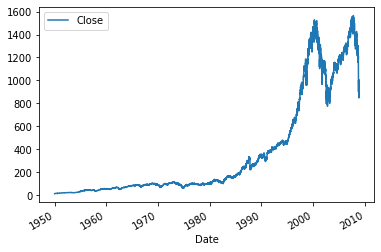

In [ ]:
dataset = ViTDataset(start_date='1950-01-03',
                            end_date='2008-11-16',
                            interval='1d',
                            normalize=True)
print("head of the dataset =", dataset.data.head()['Close'])

print("\n Plot of the 'Close' data :")
dataset.data.plot(None, ['Close'])

print(dataset.__getitem__(0)[0].shape)
print(dataset.__getitem__(0)[1].shape)
print("Taille du dataset: ", len(dataset))

# Définition du modèle
Modèle inspiré par le ViT implémenté sur [ce github](https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py) et adapté à notre cas d'usage.

In [ ]:
import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)


class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


class StockViT(nn.Module):
    def __init__(self, period_size, patch_size, nb_pred, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()

        assert period_size % patch_size == 0, 'Period dimensions must be divisible by the patch size.'

        num_patches = period_size // patch_size
        patch_dim = channels * patch_size
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (l p) -> b l (p c)', p = patch_size),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, nb_pred)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

# Mise en place de la configuration pour le modèle.

In [ ]:
class VitConfig():
    config = {
        "model":{
            "period_size" : 150,
            "patch_size" : 10,
            "nb_pred" : 10,
            "dim" : 60,
            "depth" : 8,
            "heads" : 10,
            "mlp_dim" : 60,
            "pool" : 'cls',
            "channels" : 1,
            "dim_head" : 64,
            "dropout" : 0.1,
            "emb_dropout" : 0.1
            
        },
        
        "dataset_train":{
            "start_date": '1950-01-03',
            "end_date": '2000-01-01',
            "interval_date": '1d',
            "input_size":150,
            "output_size" : 10,
            "batch_size": 256,
            "shuffle":False
        },

        "dataset_test":{
            "start_date": '2000-01-02',
            "end_date": '2010-01-01',
            "interval_date": '1d',
            "input_size":150,
            "output_size" : 10,
            "batch_size": 256,
            "shuffle":False
        },

        "dataset_val":{
            "start_date": '2010-01-02',
            "end_date": '2020-01-01',
            "interval_date": '1d',
            "input_size":150,
            "output_size" : 10,
            "batch_size": 256,
            "shuffle":False
        },

        "learning":{
            "init_lr": 1e-04,
            "lr_decay": 0.99,
            "init_epoch": 5,
            "max_epoch": 100
        } 
    }

# Instanciation des différents éléments, téléchargement des datasets ...

In [ ]:
TEST = False

# Model config
config = VitConfig().config

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

# Init the Datasets
dataset_train = ViTDataset(config["dataset_train"]["start_date"], 
                            config["dataset_train"]["end_date"],
                            config["dataset_train"]["interval_date"], 
                            config["dataset_train"]["input_size"],
                            config["dataset_train"]["output_size"])

dataset_test = ViTDataset(config["dataset_test"]["start_date"], 
                            config["dataset_test"]["end_date"],
                            config["dataset_test"]["interval_date"], 
                            config["dataset_test"]["input_size"],
                            config["dataset_test"]["output_size"])

dataset_val = ViTDataset(config["dataset_val"]["start_date"], 
                            config["dataset_val"]["end_date"],
                            config["dataset_val"]["interval_date"], 
                            config["dataset_val"]["input_size"],
                            config["dataset_val"]["output_size"])


# Init dataloader
dataloader_train = DataLoader(dataset_train, config["dataset_train"]["batch_size"], config["dataset_train"]["shuffle"], drop_last=True)#, batch_sampler = train_sampler)

# Model
model = StockViT(config["model"]["period_size"],
            config["model"]["patch_size"],
            config["model"]["nb_pred"],
            config["model"]["dim"],
            config["model"]["depth"],
            config["model"]["heads"],
            config["model"]["mlp_dim"],
            config["model"]["pool"],
            config["model"]["channels"],
            config["model"]["dim_head"],
            config["model"]["dropout"],
            config["model"]["emb_dropout"])

model.to(device)

# Learning rate to use along the epochs
learning_rate = config["learning"]["init_lr"]

# Loss
loss_fn = MSELoss()
optimizer = RMSprop(model.parameters(), lr=learning_rate, eps=1e-08)
scheduler = ExponentialLR(optimizer, gamma = config["learning"]["lr_decay"])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Entrainement

 Running for epoch 0/100
 Test loss at step 0 : 0.008663969114422798
 Running for epoch 10/100
 Test loss at step 10 : 0.0026567731983959675
 Running for epoch 20/100
 Test loss at step 20 : 0.0019429308595135808
 Running for epoch 30/100
 Test loss at step 30 : 0.0009877615375444293
 Running for epoch 40/100
 Test loss at step 40 : 0.0006156883900985122
 Running for epoch 50/100
 Test loss at step 50 : 0.000441539945313707
 Running for epoch 60/100
 Test loss at step 60 : 0.0003475790726952255
 Running for epoch 70/100
 Test loss at step 70 : 0.00031246241996996105
 Running for epoch 80/100
 Test loss at step 80 : 0.0002646374923642725
 Running for epoch 90/100
 Test loss at step 90 : 0.00025015007122419775
 Running for epoch 99/100

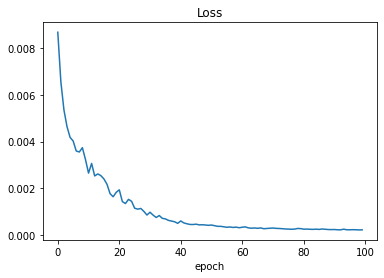

In [ ]:
# Learning
loss_list = list()
max_epoch = config["learning"]["max_epoch"]
for epoch_step in range(max_epoch):
    print("\r Running for epoch {}/{}".format(epoch_step, max_epoch), end='')
    y_pred = torch.Tensor([1])
    for i_batch, batch in enumerate(dataloader_train):
        x, y = batch
        x = x.float()
        y = y.float()
        x, y = x.to(device), y.to(device)
        y_pred = model.forward(x)
        #print("y : {}, y_pred : {}".format(y.shape,y_pred.shape))
        loss = loss_fn(y_pred, torch.squeeze(y))

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad() :
        X_test, Y_test = dataset_test.get_input_output()
        X_test = torch.unsqueeze(torch.tensor(X_test),1).float().to(device)
        Y_test = torch.tensor(Y_test).float().to(device)
        
        Y_pred = model.forward(X_test)

        loss_test = loss_fn(Y_test, Y_pred).cpu()
        if epoch_step %10 == 0 :
          print("\n Test loss at step {} : {}".format(epoch_step, loss_test))
        loss_list.append(loss_test)

    scheduler.step()

plt.plot(loss_list)
plt.title("Loss")
plt.xlabel("epoch")
plt.show()

# Test, résultats et analyses


<h2>Evolution de la qualité des prédictions si l'on s'éloigne des données d'entrée </h2>

Text(0.5, 0, "Eloignement aux données d'entrée")

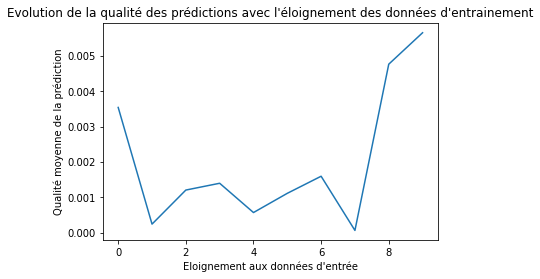

In [ ]:
with torch.no_grad() :
        X_val, Y_val = dataset_val.get_input_output()
        X_val = torch.unsqueeze(torch.tensor(X_val),1).float().to(device)
        Y_test = torch.tensor(Y_val).float().to(device)
        
        Y_pred = model.forward(X_val)

        mean = torch.abs(torch.mean(Y_test-Y_pred, axis = 0)).cpu()

plt.plot(mean)
plt.title("Evolution de la qualité des prédictions avec l'éloignement des données d'entrainement")
plt.ylabel("Qualité moyenne de la prédiction")
plt.xlabel("Eloignement aux données d'entrée")

L'objectif de ce test était de vérifier si la précision des prédictions se détériorent si l'on tente de prédire des données lointaines de celles que l'on a en entrée du réseau.
> On peut observer que dans notre cas, l'erreur est quasi similaire que l'on prédise la valeur directement suivante aux 150 prises en entrée ou bien une valeur se trouvant à un écart de 10 de la dernière valeur en entrée.

<h2>Fonctions permettant l'affichage interactif utilisé ensuite </h2>

In [ ]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-2.4.2.min.js?noext',
            },
          });
        </script>
        '''))

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 

cf.go_offline()

<h2>Comparaison entre les prédictions du réseau et les valeurs réelles </h2>
Dans la partie qui suit, nous avons affiché les courbes qui représentent d'une part les valeurs réelles(en jaune), de l'autre les valeurs prédites (en blanc). On utilise uniquement la valeur prédite directement après les 150 valeurs d'entrée pour construire la courbe de prédiction et on fait ceci tout au long de la période. 


In [ ]:
with torch.no_grad() :
        X_val, Y_val = dataset_val.get_input_output()
        X_val = torch.unsqueeze(torch.tensor(X_val),1).float().to(device)
        
        Y_pred = model.forward(X_val)[:,0].cpu()
        Y_val = Y_val[:,0]


#plt.plot(Y_pred)
#plt.plot(Y_val)
#plt.show()

epoch = config["learning"]["max_epoch"]

x_tab = np.arange(len(Y_pred))


df1 = pd.DataFrame({
    "epochs": x_tab,
    "Y_pred": Y_pred, # Remove the first value because outlier
    "Y_val" : Y_val
    })

Y_val = (Y_val + 1)*np.squeeze(dataset_val.norm_val)[:len(Y_val)]
norm_val = torch.squeeze(torch.tensor(dataset_val.norm_val))[:len(Y_val)]
Y_pred = (Y_pred + 1)*norm_val

df2 = pd.DataFrame({
    "epochs": x_tab,
    "Y_pred": Y_pred, # Remove the first value because outlier
    "Y_val" : Y_val
    })

configure_plotly_browser_state()
df1.iplot(kind='line', x='epochs', y=['Y_pred', 'Y_val'], color=['white','gold'], 
         theme='solar', mode='lines', title='Y_pred vs truth (normalized)')

df2.iplot(kind='line', x='epochs', y=['Y_pred', 'Y_val'], color=['white','gold'], 
         theme='solar', mode='lines', title='Y_pred vs truth (unnormalized)')
plt.show()

<class 'numpy.ndarray'>


On observe des résultats qui semblent être proches de la vérité terrain si l'on se fie à la seconde courbe.
Pourtant en regardant la première courbe on comprend que les variations fines ne sont pas du tout apprises et ce qui donne le caractère cohérent à la seconde courbe est l'étape de dénormalisation qui redonne la tendance originelle à la courbe prédite.

<h2> Prédiction autonome à partir des données prédites </h2>

Dans cette partie, on prend en entrée les 150 premières valeurs du set de validation dans un vecteur $X_{val}$. Puis pour chaque nouvelle prédiction, on actualise ce vecteur de la manière suivante : 

$X_{val} \leftarrow X_{val}[1:]\cup \{pred\}$ 

tout en tenant compte de la normalisation (on note $(v_i)_{0\leq i\leq longeur\_du\_dataset}$ les valeur de normalisation) :

$X_{val} \leftarrow \frac{(X_{val}+1)\times v_{i-1}}{v_i}-1$
Puis on effectue la prédiction de l'itération suivante.

In [ ]:
pred_list = list()
with torch.no_grad():
    X_val, _ = dataset_val[0]
    X_val = torch.unsqueeze(torch.tensor(X_val),1).float().to(device) 
    for i in range(1,len(dataset_val)):
        Y_pred = model.forward(X_val)[:,0].cpu()
        X_tmp = X_val.clone()
        X_val[0,0,:-1] = X_tmp[0,0,1:]
        X_val[0,0,-1] = Y_pred[0]
        v0, v1 = torch.tensor(dataset_val.get_normalization_value(i-1)).to(device), torch.tensor(dataset_val.get_normalization_value(i)).to(device)
        X_val = (X_val + 1)*v0
        pred_list.append(X_val[0,0,0])
        X_val = (X_val/v1 - 1).float()
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [ ]:
pred = np.zeros((len(pred_list)))
_ , Y_val = dataset_val.get_input_output()
Y_truth = Y_val[:,0]
Y_truth = (Y_truth + 1)*np.squeeze(dataset_val.norm_val)[:len(Y_truth)]
for i in range(len(pred_list)):
  pred[i] = pred_list[i].cpu()


df1 = pd.DataFrame({
    "epochs": x_tab[1:],
    "Y_pred": pred, # Remove the first value because outlier
    "Y_truth" : Y_truth[1:]
    })

configure_plotly_browser_state()
df1.iplot(kind='line', x='epochs', y=['Y_pred', 'Y_truth'], color=['white','gold'], 
         theme='solar', mode='lines', title='Y_pred vs truth (normalized)')

plt.show()

On observe que les valeurs prédites sont rapidement éloignés des vérités terrain mais que la tendance reste cependant cohérente. Cela peut cependant surement s'expliquer par l'étape de dénormalisation comme vu précédement.